In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import os

In [2]:
#print the list of paths of files in the training set
set_path = 'train'
paths = sorted(glob.glob(f'data/{set_path}/*.hdf5'))
print(paths)

['data/train/acoustic_scattering_maze_2d_chunk_0.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_1.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_10.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_11.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_12.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_13.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_14.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_15.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_2.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_3.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_4.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_5.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_6.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_7.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_8.hdf5', 'data/train/acoustic_scattering_maze_2d_chunk_9.hdf5']


In [3]:
#select the first path (arbitrary choice)
p = paths[0]

#print the first layer of keys
with h5py.File(p,'r') as f:
    print(f.keys())

<KeysViewHDF5 ['boundary_conditions', 'dimensions', 'scalars', 't0_fields', 't1_fields', 't2_fields']>


In [4]:
# In 'boundary_conditions' is stored the information about the boundary conditions:
with h5py.File(p,'r') as f:
    print('print bc available:', f['boundary_conditions'].keys())
    print('print attributes of the bc:', f['boundary_conditions']['x_wall'].attrs.keys())
    print('get the bc type:', f['boundary_conditions']['x_wall'].attrs['bc_type'])

print bc available: <KeysViewHDF5 ['x_wall', 'y_open']>
print attributes of the bc: <KeysViewHDF5 ['associated_dims', 'associated_fields', 'bc_type', 'sample_varying', 'time_varying']>
get the bc type: WALL


In [5]:
#Reminder: 't0_fields', 't1_fields', 't2_fields' are respectively scalar fields, vector fields and tensor fields
#print the different fields available in the dataset
with h5py.File(p,'r') as f:
    print('t0_fields:', f['t0_fields'].keys())
    print('t1_fields:', f['t1_fields'].keys())
    print('t2_fields:', f['t2_fields'].keys())

t0_fields: <KeysViewHDF5 ['bulk_modulus', 'density', 'pressure']>
t1_fields: <KeysViewHDF5 ['velocity']>
t2_fields: <KeysViewHDF5 []>


In [6]:
#The data is of shape (n_trajectories, n_timesteps, x, y)
#Get the first t0_field and save it as a numpy array
with h5py.File(p,'r') as f:
    density = f['t0_fields']['density'][:] #HDF5 datasets can be sliced like a numpy array
    print(f'shape of the selected t0_field: ', density.shape)   

    #you can directly slice the selected field without reading the whole dataset by doing:
    #traj = 0 #select the trajectory
    # field = f['t0_fields']['concentration'][traj, :] 

shape of the selected t0_field:  (100, 256, 256)


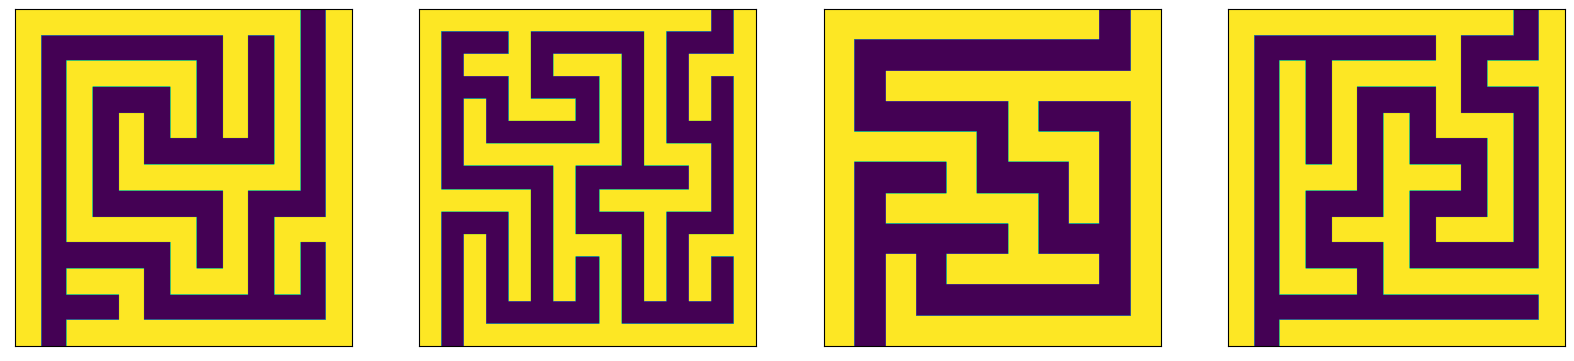

In [7]:
traj = 1 #select the trajectory
traj_toplot = density#[traj]
#field is now of shape (n_timesteps, x, y). Let's do a subplot to plot it at t= 0, t= T/3, t= 2T/3 and t= T:
fig, axs = plt.subplots(1, 4, figsize=(20,5))
T = traj_toplot.shape[0]
#fix colorbar for all subplots:
vmin = np.min(traj_toplot)
vmax = np.max(traj_toplot)
norm = plt.Normalize(vmin=vmin, vmax=vmax)

for i, t in enumerate([0, T//3, (2*T)//3, T-1]):
    axs[i].imshow(traj_toplot[t], cmap='viridis')#),norm=norm)
    #axs[i].set_title(f't={t}')
    axs[i].set_xticks([])
    axs[i].set_yticks([])



In [19]:
#save figure without axes and titles:

image_name = 'pattern_formation_A_unnormalized'
path_to_save = '/mnt/home/polymathic/ceph/the_well/viz/'
fig.savefig(f'{path_to_save}{image_name}.png', bbox_inches='tight', pad_inches=0.05)

In [3]:
#Transform an attribute:
tt = ['data/train', 'data/valid', 'data/test']
for t in tt:
    paths = sorted(glob.glob(f'{t}/*.hdf5'))
    for p in paths:
        with h5py.File(p,'r+') as f:
            attrs = f['boundary_conditions']['x_periodic'].attrs
            bc_type = attrs['bc_type']
            bc_type = 'periodic'
            attrs['bc_type'] = bc_type
            print(f['boundary_conditions']['x_periodic'].attrs['bc_type'])

In [28]:
import os
import imageio
import numpy as np
import matplotlib.pyplot as plt
import shutil
from tqdm import tqdm
def create_gif(time_series, saving_directory, name_file = 'concentration', delete_imgs=False):
    time_series_min = time_series.min()
    time_series_max = time_series.max()
    if time_series.ndim > 3:
        #error:
        print('Error: The time series should be (time, height, width)')
        return
    if not os.path.exists(saving_directory + '/img_for_gif'):
        os.makedirs(saving_directory + '/img_for_gif')
    images = []
    for i in range(0, time_series.shape[0],10):
        plt.imshow(time_series[i], origin='lower', vmin=time_series_min, vmax=time_series_max);
        #plt.show()
        plt.axis('off')
        plt.savefig(saving_directory + f'/img_for_gif/time_series_{i}.png', bbox_inches='tight', pad_inches=0)
        plt.close()
        images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))

    imageio.mimsave(saving_directory + '/' + name_file + '.gif', images, duration=0.1)
    if delete_imgs:
        shutil.rmtree(saving_directory + '/img_for_gif')

In [29]:
create_gif(A[traj], 'gif', name_file='concentration_A_normalized', delete_imgs=True)

/tmp/ipykernel_3149559/2385934574.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(saving_directory + f'/img_for_gif/time_series_{i}.png'))
